In [3]:
import math
from botorch.utils import t_batch_mode_transform
import torch
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models import  SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.monte_carlo import AcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch.optim.initializers import gen_batch_initial_conditions
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms.outcome import Standardize

#kernels
from gpytorch.kernels import RBFKernel

problem setting

Two Bar Truss Design

In [4]:
from design import Design
from botorch.utils.sampling import draw_sobol_samples
problem = Design()

def test_f(X):
    return problem.evaluate(X.to(torch.float64))
bounds = problem.bounds
def generate_initial_data(n):
    # generate training data
    train_x = (draw_sobol_samples(bounds=bounds, n=n, q=1).squeeze(1)).to(torch.float64)
    train_obj, train_const = test_f(train_x)
    return train_x, train_obj, train_const

In [5]:
generate_initial_data(2)

(tensor([[  72.4926,   80.7180, 1221.4901,   11.1833],
         [  67.3461,  102.5224, 2452.8333,   19.3541]], dtype=torch.float64),
 tensor([[-0.6288, -6.2501],
         [-5.3739, -1.6008]], dtype=torch.float64),
 tensor([[-1.1775e+01,  9.1314e-02,  7.5250e-01,  4.0893e+04],
         [ 1.5176e+01,  2.6927e-01,  8.8224e-01,  1.6228e+05]],
        dtype=torch.float64))

acquisition

In [6]:
from botorch.acquisition import AnalyticAcquisitionFunction
import torch

class HyperVolumeScalarizedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        Initializes the HyperVolume Scalarized Upper Confidence Bound Acquisition Function.

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        std_devs = posterior.variance.squeeze(dim=-2).sqrt()  # b x o
        m = means.shape[1]
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x o

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.max(torch.zeros_like(u_t), u_t / self.theta) ** m, dim=-1)[0]  # b

        return scalarized_ut


Auxiliary Acq

In [7]:
class AuxiliaryAcq(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        An auxiliary acquisition defined in Algo.2

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(MCAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform()
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        #print(posterior.mean.shape)
        means = posterior.mean  # b x q x o
        std_devs = posterior.variance.sqrt()  # b x q x o
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x qx o
        #print('233', u_t.shape)

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.min(u_t, dim=-1)[0], dim=-1)[0]  # b
        return scalarized_ut


constraints

In [8]:
import torch
from typing import List, Tuple, Callable

def create_ucb_constraints(model, beta: float, thresholds: torch.Tensor):
    """
    Creates a list of non-linear inequality constraints for a multi-output GP model, ensuring that the upper confidence
    bounds of the model's outputs are greater than or equal to the specified thresholds.

    Args:
        model (MultiTaskGP): A multi-output Gaussian Process model.
        beta (float): The scalar coefficient for the variance component of the UCB.
        thresholds (torch.Tensor): A tensor of thresholds for each output dimension.

    Returns:
        List[Tuple[Callable, bool]]: A list of tuples, each containing a callable constraint and a boolean indicating
                                      whether the constraint is intra-point (True) or inter-point (False). Each callable
                                      takes a tensor `X` of shape [q, d] (where `d` is the dimension of the input space
                                      and `q` can be 1 or more representing different design points) and returns a scalar
                                      that should be non-negative if the constraint is satisfied.
    """
    
    def constraint(X):
        """
        Evaluates all constraints for a batch of design points.

        Args:
            X (torch.Tensor): A tensor of shape [q, d] (where `d` is the dimension of the input space and `q` can be 1 or more 
                              representing different design points).

        Returns:
            torch.Tensor: A tensor of shape [q, m] (where `m` is the number of output dimensions) containing the evaluated 
                          constraints.
        """
        # Compute posterior at X
        X = X.unsqueeze(0)
        posterior = model.posterior(X)
        mean = posterior.mean
        variance = posterior.variance
        ucb = mean + beta * variance.sqrt()  # Compute the UCB

        # Evaluate all constraints and return the difference from thresholds
        return ucb - thresholds

    # Create a list of constraints for each output dimension, all set as intra-point since they evaluate individually
    constraints = [(lambda X, i=i: constraint(X)[:, i], True) for i in range(thresholds.size(0))]

    return constraints


In [9]:
def get_random_sample_on_n_sphere(N, R):
    # Return a single sample of a vector of dimension N
    # with a uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html
    
    # Generate a normally distributed point
    X = torch.randn(N)

    # Normalize this point to the surface of the sphere, then scale by radius R
    return R * X / torch.norm(X)

BO loop

take thresholds to be: -1.9, -2.25

kernel picking

In [10]:
# from Customized_Kernels import Customized_RBF, Customized_Matern
from metrics import HV, violation
# rbf_module = Customized_RBF(2,2)
# matern_module = Customized_Matern(1,0.5,1)

In [12]:
import warnings

warnings.filterwarnings('ignore')
import time
c = 0
print('0'*50)
random_seeds = [83810, 14592, 3278, 97196, 36048, 32098, 29256, 18289, 96530, 13434, 88696, 97080, 71482, 11395, 77397, 55302, 4165, 3905, 12280, 28657, 30495, 66237, 78907, 3478, 73563,
26062, 93850, 85181, 91924, 71426, 54987, 28893, 58878, 77236, 36463, 851, 99458, 20926, 91506, 55392, 44597, 36421, 20379, 28221, 44118, 13396, 12156, 49797, 12676, 47052]
declared = False
for seed in random_seeds[:10]:
    torch.manual_seed(seed)
    train_X, train_Y, train_Con = generate_initial_data(10)
    train_X = normalize(train_X, bounds)
    c+=1
    torch.save(train_X, f'train_domain_design_{c}.pt')
    # continue
    train_X_r, train_Y_r, train_Con_r = train_X, train_Y, train_Con
    a = -8
    b = -8
    thresholds = torch.tensor([a,b], dtype= torch.float64)
    Hpv = []
    Hpvr = []
    NUM_ITER = 100
    for batch in range(NUM_ITER):
        t0 = time.monotonic()
        model_list = []
        model_list_const = []
        m = 2
        m_c = 4
        for i in range(m):
            current_model = SingleTaskGP(train_X= train_X, train_Y= train_Y[:, i].unsqueeze(-1), outcome_transform= Standardize(m = 1), train_Yvar= torch.zeros((train_X.shape[0],1)) + 0.05**2)
            model_list.append(current_model)
        for i in range(m_c):
            current_model_const = SingleTaskGP(train_X = train_X, train_Y = train_Con[:, i].unsqueeze(-1))
            model_list_const.append(current_model_const)
        model = ModelListGP(*model_list)
        model_const = ModelListGP(*model_list_const)
        mll_model = SumMarginalLogLikelihood(model.likelihood, model)
        mll_const = SumMarginalLogLikelihood(model_const.likelihood, model)
        fit_gpytorch_mll(mll_model)
        fit_gpytorch_mll(mll_const)
        #t1 = time.monotonic()
        #sample theta from distribution
        theta = get_random_sample_on_n_sphere(m,1).abs()
        beta = 0.4* math.log(2*((batch+1)))
        beta_const = 0.2 * math.log(((batch+1)))

        #auxiliary acquisition
        AuxAcq = AuxiliaryAcq(model= model_const, beta= torch.tensor(beta_const), theta = theta, ref= torch.tensor([0,0,0,0]))
        initializer, acq_value = optimize_acqf(
            acq_function = AuxAcq,
            q = 3,
            num_restarts = 10,
            raw_samples = 10,
            bounds = torch.tensor([[0.0]*4, [1.0]*4])
        )
        #declare
        if acq_value < 0: 
            declared = True
            break
        #t2 = time.monotonic()
        #create acquisition function
        HVUCB = HyperVolumeScalarizedUCB(model= model, beta= torch.tensor(beta), theta = theta, ref= thresholds)
        #optimize constraint function
        candidate, acq_scalar = optimize_acqf(
            acq_function = HVUCB,
            q = 1,
            num_restarts = 4,
            nonlinear_inequality_constraints = create_ucb_constraints(beta=beta_const, model= model_const, thresholds= torch.tensor([0,0,0,0])),
            #ic_generator = gen_batch_initial_conditions,
            batch_initial_conditions = initializer.view([-1,1,4]),
            #take the standard bounds
            bounds = torch.tensor([[0.0]*4, [1.0]*4]),
            options = {"batch_limit": 1, "maxiter": 500}
        )
        #t3 = time.monotonic()
        #update data
        train_X = torch.cat([train_X, candidate],dim=0)
        new_y, new_con = test_f(unnormalize(candidate, bounds= bounds))
        train_Y = torch.cat([train_Y, new_y], dim = 0)
        train_Con = torch.cat([train_Con, new_con], dim = 0)
        vio = torch.where(train_Con < 0, -train_Con, torch.zeros_like(train_Con)).sum(dim = -1)
        feasi_ind = vio == 0
        hv = HV(Y = train_Y[feasi_ind, :], ref = thresholds)
        Hpv.append(hv)
        #random
        new_x_r, new_con_r, new_y_r  = generate_initial_data(1)
        new_x_r = normalize(new_x_r, bounds)
        new_y_r, new_con_r = test_f(unnormalize(new_x_r, bounds= bounds))
        train_Y_r = torch.cat([train_Y_r, new_y_r], dim = 0)
        train_Con_r = torch.cat([train_Con_r, new_con_r], dim = 0)
        vio_r = torch.where(train_Con_r < 0, -train_Con_r, torch.zeros_like(train_Con_r)).sum(dim = -1)
        feasi_ind_r = vio_r == 0
        hv_r = HV(Y = train_Y_r[feasi_ind_r, :], ref = thresholds)
        Hpvr.append(hv_r)
        print(f'round{batch+1}', 'CMOBO: ', hv, 'random: ', hv_r)
    if not declared:
        c+=1
        torch.save(torch.tensor(Hpv), f'hv_design_cmobo_0.4_{c}.pt')
        torch.save(torch.tensor(vio), f'vio_design_cmobo_0.4_{c}.pt')
        torch.save(torch.tensor(Hpvr), f'hv_design_rand_{c}.pt')
        torch.save(torch.tensor(vio_r), f'vio_design_rand_{c}.pt')
        print('o', end='')
    else:
        print('*', end='')
    declared = False

00000000000000000000000000000000000000000000000000


In [13]:
print(train_Con)

tensor([[-5.8673e+00,  3.6059e-02,  7.1640e-01,  8.6719e+04],
        [ 6.6624e+00,  2.6144e-01,  8.8016e-01,  1.0641e+05],
        [-7.4185e+00, -2.3628e-02,  6.3502e-01,  1.1964e+05],
        [ 2.6430e+01,  3.4732e-01,  9.5393e-01,  7.4488e+04],
        [ 9.9093e+00,  2.8913e-01,  9.1444e-01,  8.6010e+04],
        [ 8.7079e+00,  2.7865e-01,  8.8202e-01,  1.1354e+05],
        [-1.5579e+01, -1.4437e-01,  5.7209e-01,  5.4469e+04],
        [ 1.7058e+01,  2.5837e-01,  8.7953e-01,  1.0164e+05],
        [ 7.3569e+00,  3.2011e-01,  9.3520e-01,  4.6765e+04],
        [ 1.1719e+01,  2.5258e-01,  8.6458e-01,  1.7293e+05]],
       dtype=torch.float64)


Simple HV

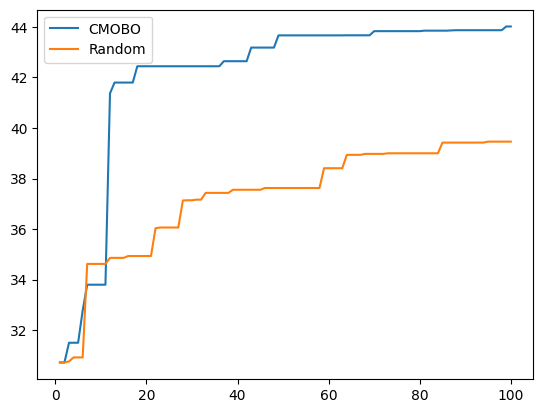

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(Hpv) + 1), Hpv)
plt.plot(range(1, len(Hpvr) + 1), Hpvr)
plt.legend(['CMOBO', 'Random'])

Text(0.5, 1.0, 'Cumulative Violation')

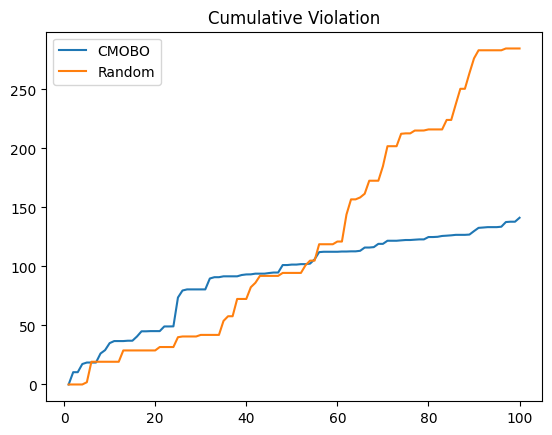

In [11]:
from metrics import cum_violation
cum_vio = cum_violation(vio[10:])
cum_vio_r=  cum_violation(vio_r[10:])
plt.plot(range(1,101), cum_vio)
plt.plot(range(1,101), cum_vio_r)
plt.legend(['CMOBO', 'Random'])
plt.title('Cumulative Violation')

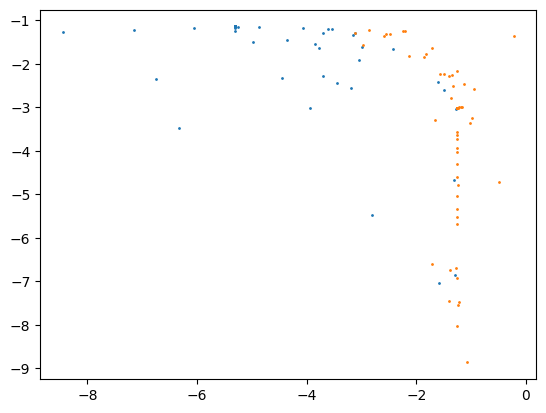

In [12]:
plt.scatter(train_Y[feasi_ind,:][:,0], train_Y[feasi_ind,:][:,1],s = 1)
plt.scatter(train_Y[~feasi_ind,:][:,0], train_Y[~feasi_ind,:][:,1], s = 1)